In [7]:
# Linear regression(multivariate)
# identifying the problem -> predicting house prices
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
# making random initializations predictable
np.random.seed(42)

In [8]:
# load the housing dataset (please make sure that you have downloded the dataset to your local machine before running the following line)
df = pd.read_csv('./data/housing.csv')

In [9]:
# Exploratory analysis
print(f"dataframe shape:\n{df.shape}\n")
print(f"dataframe columns:\n{df.columns}\n")
print(f"dataframe sample:\n{df.head()}\n")

dataframe shape:
(20640, 10)

dataframe columns:
Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

dataframe sample:
   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         

In [10]:
# Exploratory analysis
# NOTE: instead of the data types, you will be able to see how much space the dataframe has taken in memory
print(f"dataframe info:\n{df.info()}\n")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB
dataframe info:
None



In [11]:
# Exploratory analysis
print(f"value counts:\n{df['ocean_proximity'].value_counts()}\n")

value counts:
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64



In [12]:
# Exploratory analysis
print(f"describe the dataset:\n{df.describe()}\n")

describe the dataset:
          longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20640.000000  20640.000000   20640.000000   
mean       537.870553   1425.476744    499.539680       3.870671   
std        421.385070   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900  

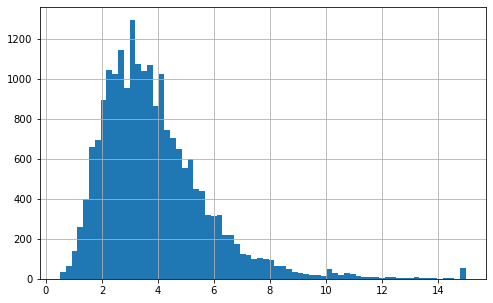

In [13]:
# Exploratory analysis
# plot(using a histogram) each column by seperating data into 50 bins
df['median_income'].hist(bins=70, figsize=(8,5))
plt.show()

In [14]:
# one way to preparing your train and test data
# NOTE: a random train/test split could introduce sample bias
data_train, data_test = train_test_split(df, test_size=0.2, random_state=42)

In [15]:
# the sampling bias is not that evident in this dataset
print(df.describe())
print(data_train.describe())
print(df.head())

          longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20640.000000  20640.000000   20640.000000   
mean       537.870553   1425.476744    499.539680       3.870671   
std        421.385070   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   
25%        296.00000

data split based on the income category:
3    7236
2    6581
4    3639
5    2362
1     822
Name: income_cat, dtype: int64


<AxesSubplot:>

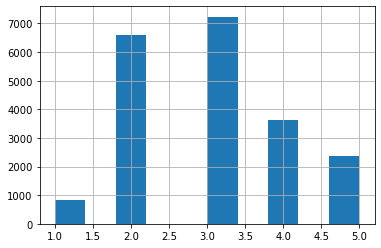

In [16]:
# preparing the data to be shuffled split
# NOTE: for shuffle split, you need to identify a specific feature so that you can preserve the percentage in each sample
# creating labels for each bin(e.g., 0 -> 1.5 = 1, 6.0 -> positive infinity = 5)
df["income_cat"] = pd.cut(df["median_income"], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1, 2, 3, 4, 5])

print(f"data split based on the income category:\n{df['income_cat'].value_counts()}")

# print histogram of the income categories
df["income_cat"].hist()

In [17]:
# stratified(i.e., preserving the percentage of samples under each class) shuffle splitting the dataset
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df["income_cat"]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

# to make sure that we have preserved the categorical feature distribution in the test dataset compared to the original dataset
print(strat_test_set["income_cat"].value_counts() / len(strat_test_set))
print(df["income_cat"].value_counts() / len(df))

# drop the categorical feature as we do not need it anymore
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64
3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64


In [18]:
# identifying the correlation between features
# NOTE: if certain features are highly correlated, you can drop one of the correlated features to reduce the dimensionality of the feature space
corr_matrix = df.corr()
# print(corr_matrix)
print(corr_matrix['median_income'].sort_values(ascending=False))

median_income         1.000000
median_house_value    0.688075
total_rooms           0.198050
households            0.013033
population            0.004834
total_bedrooms       -0.007723
longitude            -0.015176
latitude             -0.079809
housing_median_age   -0.119034
Name: median_income, dtype: float64


#### Model Development

In [19]:
# model development
# prepare the data
# drop label column(axis=1) from the training dataset
# remember that dataframes are mutable(i.e., reason for using .copy())
data = strat_train_set.drop("median_house_value", axis=1) 
labels = strat_train_set["median_house_value"].copy()

In [20]:
# check to see if there are any missing data
sample_incomplete_rows = data[data.isnull().any(axis=1)].head()
print(sample_incomplete_rows)
print(sample_incomplete_rows.shape)

       longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
1606     -122.08     37.88                26.0       2947.0             NaN   
10915    -117.87     33.73                45.0       2264.0             NaN   
19150    -122.70     38.35                14.0       2313.0             NaN   
4186     -118.23     34.13                48.0       1308.0             NaN   
16885    -122.40     37.58                26.0       3281.0             NaN   

       population  households  median_income ocean_proximity  
1606        825.0       626.0         2.9330        NEAR BAY  
10915      1970.0       499.0         3.4193       <1H OCEAN  
19150       954.0       397.0         3.7813       <1H OCEAN  
4186        835.0       294.0         4.2891       <1H OCEAN  
16885      1145.0       480.0         6.3580      NEAR OCEAN  
(5, 9)


In [21]:
# using the sklearn imputer to fill missing values
# getting the median of the feature to complete the missing values
imputer = SimpleImputer(strategy="median")
# because the median is calculated on numerical data, we need to drop categorical features from the dataframe
housing_num = data.drop("ocean_proximity", axis=1)
print(data.shape)
print(housing_num.shape)
# fitting the data on the imputer so that it can apply the required statistical function on the training data
imputer.fit(housing_num)
# printing the calculated statistical measurements
print(imputer.statistics_)
# for comparison, calculate the statistical measurements on the training dataset without using the imputer
print(housing_num.median().values)

(16512, 9)
(16512, 8)
[-118.51      34.26      29.      2119.       433.      1164.
  408.         3.54155]
[-118.51      34.26      29.      2119.       433.      1164.
  408.         3.54155]


In [22]:
# transform the dataset to have the computed median
input_x = imputer.transform(housing_num)
print(input_x.shape)
print(type(input_x))

# creating the dataframe from the 2D numpy array
housing_train = pd.DataFrame(input_x, columns=housing_num.columns, index=housing_num.index)

# see what is imputed into the missing value cells
print(housing_train.loc[sample_incomplete_rows.index.values])

print(housing_train.head())

(16512, 8)
<class 'numpy.ndarray'>
       longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
1606     -122.08     37.88                26.0       2947.0           433.0   
10915    -117.87     33.73                45.0       2264.0           433.0   
19150    -122.70     38.35                14.0       2313.0           433.0   
4186     -118.23     34.13                48.0       1308.0           433.0   
16885    -122.40     37.58                26.0       3281.0           433.0   

       population  households  median_income  
1606        825.0       626.0         2.9330  
10915      1970.0       499.0         3.4193  
19150       954.0       397.0         3.7813  
4186        835.0       294.0         4.2891  
16885      1145.0       480.0         6.3580  
       longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
12655    -121.46     38.52                29.0       3873.0           797.0   
15502    -117.23     33.09                 7.0    

In [23]:
# what are Ordinal Variables: 
# limited number of distinct values with a ranked ordering
housing_cat = data[["ocean_proximity"]]
print(housing_cat.head(10))
print(housing_cat.value_counts())

# encoding the categorical features
ordinal_encoder = OrdinalEncoder()
# NOTE: fitting and transforming data in a single step
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
print(housing_cat_encoded[:10])
print(ordinal_encoder.categories_)

# NOTE: ML algorithms will misinterpret if variable is encoded into an Ordinal feature
# NOTE: Certain algorithms such as decision trees and random forests can work with such encoded data

      ocean_proximity
12655          INLAND
15502      NEAR OCEAN
2908           INLAND
14053      NEAR OCEAN
20496       <1H OCEAN
1481         NEAR BAY
18125       <1H OCEAN
5830        <1H OCEAN
17989       <1H OCEAN
4861        <1H OCEAN
ocean_proximity
<1H OCEAN          7277
INLAND             5262
NEAR OCEAN         2124
NEAR BAY           1847
ISLAND                2
dtype: int64
[[1.]
 [4.]
 [1.]
 [4.]
 [0.]
 [3.]
 [0.]
 [0.]
 [0.]
 [0.]]
[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)]


In [24]:
# NOTE: to overcome the limitations with the OrdinalEncoder, we use one-hot encoding
cat_encoder = OneHotEncoder(sparse=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
print(housing_cat)
print(housing_cat_1hot)
print(cat_encoder.categories_)

      ocean_proximity
12655          INLAND
15502      NEAR OCEAN
2908           INLAND
14053      NEAR OCEAN
20496       <1H OCEAN
...               ...
15174       <1H OCEAN
12661          INLAND
19263       <1H OCEAN
19140       <1H OCEAN
19773          INLAND

[16512 rows x 1 columns]
[[0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]
[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)]


In [25]:
# creating a pipeline so that you can chain together multiple steps
# NOTE: remember that the output from one step will be an inout to the other
# you can do these steps seperately and combine but Pipelines are more efficient
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

# will be applying tranasformer object to the given subset of data
# NOTE: e.g., the "num_pipeline" transformer object will be applied on the given set of columns
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

 # sending the data through a chain of transformations
 # NOTE: the final dataset is a 2D numpy array containg all numerical data
housing_prepared = full_pipeline.fit_transform(data)
print(housing_prepared)

[[-0.94135046  1.34743822  0.02756357 ...  0.          0.
   0.        ]
 [ 1.17178212 -1.19243966 -1.72201763 ...  0.          0.
   1.        ]
 [ 0.26758118 -0.1259716   1.22045984 ...  0.          0.
   0.        ]
 ...
 [-1.5707942   1.31001828  1.53856552 ...  0.          0.
   0.        ]
 [-1.56080303  1.2492109  -1.1653327  ...  0.          0.
   0.        ]
 [-1.28105026  2.02567448 -0.13148926 ...  0.          0.
   0.        ]]


In [26]:
# training a linear regression model
# NOTE: n_jobs -> number of processors to use for the computation (-1: indicates all the processors)
lin_reg = LinearRegression(n_jobs=-1)

# NOTE: we are using the transformed training data(housing_prepared) when training the model
lin_reg.fit(housing_prepared, labels)
some_data = data.iloc[:5]
some_labels = labels.iloc[:5]

# remember only to transform the data when preparing data for prediction
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))
print("Actual Labels:", list(some_labels))

Predictions: [ 88983.14806384 305351.35385026 153334.71183453 184302.55162102
 246840.18988841]
Actual Labels: [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


In [27]:
# using the trained model to predict on the same training dataset
housing_predictions = lin_reg.predict(housing_prepared)

# calculating the root mean squared error 
lin_rmse = mean_squared_error(labels, housing_predictions, squared=False)
print(lin_rmse)

# NOTE: the error indicates that the model is underfitting the training data
# NOTE: can train a more powerful model or train the model with more informative features

69050.56219504567


In [28]:
# using a more powerful model to do the prediction
rf_reg = RandomForestRegressor(n_estimators=100, bootstrap=False, n_jobs=-1)
rf_reg.fit(housing_prepared, labels)
housing_predictions = rf_reg.predict(housing_prepared)
rf_rmse = mean_squared_error(labels, housing_predictions, squared=False)
print(rf_rmse)
# train the model with different number of estimators
# 200 -> 18223
# 100 -> 18479
# 50 -> 18657
# 300 -> 18105
# bootstrap: True / False

0.0


In [29]:
# how to idnetify a well generalized model
model = RandomForestRegressor(n_estimators=100, bootstrap=False, n_jobs=-1)
# model = SVR()
# model = LinearRegression(n_jobs=-1)
# NOTE: the number of folds to choose depends on the dataset size
# NOTE: becuase the metric has to be maximized we use "neg_mean_squared_error"
scores = cross_val_score(model, housing_prepared, labels, scoring="neg_mean_squared_error", cv=10, n_jobs=-1)
rmse = np.sqrt(-scores)
print(rmse)
print(f"Mean: {np.mean(rmse)}")
print(f"STD: {np.std(rmse)}")

[68200.77417071 66990.7657478  62035.16531414 66275.80000723
 65338.40999417 65896.67815355 69528.83592576 66783.24658446
 64612.82527938 68689.60146741]
Mean: 66435.21026446194
STD: 2059.11797638143


In [30]:
# test the model on test data
x_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

x_test_prepared = full_pipeline.transform(x_test)
final_predictions = rf_reg.predict(x_test_prepared)

rf_test_rmse = mean_squared_error(y_test, final_predictions, squared=False)
print(rf_test_rmse)

66263.32189428688


#### Hyperparameter Tuning

In [32]:
# Using sklearn GridSearchCV for hyperparameter tuning
# initialize the model
model = RandomForestRegressor(random_state=42, n_jobs=-1)
# specify the parameter combinations to be tested
parameters = [
    {'n_estimators': [100, 200, 300]},
    {'bootstrap': [False], 'n_estimators': [100, 200, 300]}
]

# NOTE: becuase the metric has to be maximized we use "neg_mean_squared_error"
grid_search = GridSearchCV(model, parameters, cv=5, scoring='neg_mean_squared_error', return_train_score=True, n_jobs=-1)
grid_search.fit(housing_prepared, labels)

# print the best parameters
print(grid_search.best_params_)
# the best estimator
print(grid_search.best_estimator_)
# can also get the best results for each run with different feature combinations
cross_val_results = grid_search.cv_results_

cvscr = grid_search.cv_results_
for mean_score, params in zip(cross_val_results['mean_test_score'], cross_val_results['params']):
    print(params)
    print(np.sqrt(-mean_score))

print()
# NOTE: if you are not clear about the possible hyperparameter values to be searched, you can use RandomizedSearchCV to randomly search for the best hyperparameters(i.e., from the distributions) given the number of iterations
# e.g., 
# random_search = RandomizedSearchCV(model, distributions, n_iter=500, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1, random_state=42)

# because refit=True in the default settings the best model will be trained on the entire dataset and the trained model can be used to do the predictions on the test dataset
predictions_test = grid_search.best_estimator_.predict(x_test_prepared)
test_error = mean_squared_error(y_test, predictions_test, squared=False)
print(test_error)

predictions_train = grid_search.best_estimator_.predict(housing_prepared)
train_error = mean_squared_error(labels, predictions_train, squared=False)
print(train_error)

{'n_estimators': 300}
RandomForestRegressor(n_estimators=300, n_jobs=-1, random_state=42)
{'n_estimators': 100}
49947.52967876522
{'n_estimators': 200}
49729.12139602256
{'n_estimators': 300}
49637.81989751094
{'bootstrap': False, 'n_estimators': 100}
67272.12382719346
{'bootstrap': False, 'n_estimators': 200}
67280.55989713506
{'bootstrap': False, 'n_estimators': 300}
67269.60679726377

47049.48654975903
18064.80993984425


In [33]:
cvscr = grid_search.cv_results_
for mean_score, params in zip(cvscr['mean_test_score'], cvscr['params']):
    print(np.sqrt(-mean_score))


49947.52967876522
49729.12139602256
49637.81989751094
67272.12382719346
67280.55989713506
67269.60679726377


RandomForestRegressor(n_estimators=300, n_jobs=-1, random_state=42)
[481595.27666667 212161.71666667 206602.33333333 ... 343622.14333333
 310300.06333333 223952.33333333]
47049.48654975903